In [6]:
from birdset.datamodule.base_datamodule import DatasetConfig
from birdset.datamodule.birdset_datamodule import BirdSetDataModule
from birdset.datamodule.pretrain_datamodule import PretrainDataModule, BirdSetTransformsWrapper

import matplotlib.pyplot as plt
from IPython.display import Audio
from torchaudio.compliance.kaldi import fbank
import torch
from tqdm import tqdm

### Load focal pretraining dataset (XCL) from existing data directory on cluster

In [2]:
XCL_PATH = '/mnt/datasets/bird_recordings/birdset_hf_download/XCL/XCL_processed_3_e2056aa472804029'

In [8]:
dm = PretrainDataModule(
    dataset= DatasetConfig(
        data_dir=XCL_PATH,
        dataset_name='XCL',
        hf_path='DBD-research-group/BirdSet',
        hf_name='XCL',
        n_workers=3,
        val_split=0.2,
        task="multiclass",
        classlimit=500,
        eventlimit=1,
        sampling_rate=32000,
        direct_fingerprint=XCL_PATH
    ),
    transforms=BirdSetTransformsWrapper(
        model_type='waveform'
    )
)

In [9]:
dm.prepare_data()
dm.setup('fit')

Loading dataset from disk:   0%|          | 0/240 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/240 [00:00<?, ?it/s]

In [4]:
sample = dm.train_dataset[0]
audio = sample['input_values']
label = sample['labels']

print(f'Audio shape {audio.shape}')
print(f'Label shape {label.shape}')

Audio(audio, rate=32000)

Audio shape torch.Size([1, 160000])
Label shape torch.Size([51])


### Load Finetuning dataset (HSN focal)

In [2]:
dm = BirdSetDataModule(
    dataset= DatasetConfig(
        data_dir='/mnt/stud/work/deeplearninglab/ss2024/ssl-1/data_birdset/NBP',
        dataset_name='NBP',
        hf_path='DBD-research-group/BirdSet',
        hf_name='NBP',
        n_workers=3,
        val_split=0.2,
        task="multilabel",
        classlimit=500,
        eventlimit=1,
        sampling_rate=32000,
    ),
    transforms=BirdSetTransformsWrapper(
        model_type='waveform'
    )
)

In [3]:
# Train (focal)
dm.prepare_data()
dm.setup(stage="fit")

sample = dm.train_dataset[0]
audio = sample['input_values']
label = sample['labels']

print(audio.shape)
print(label.shape)

One-hot-encoding (num_proc=3):   0%|          | 0/26579 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21263 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5316 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/539 [00:00<?, ? examples/s]

torch.Size([1, 160000])
torch.Size([51])


torch.Size([998, 128])


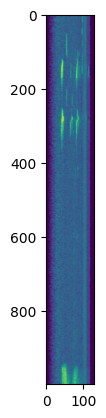

In [33]:
spectrogram = fbank(audio, htk_compat=True, sample_frequency=16000, use_energy=False, window_type='hanning', num_mel_bins=128, dither=0.0, frame_shift=10)

plt.imshow(spectrogram)
print(spectrogram.shape)

Audio(audio, rate=32000)

In [8]:
# Check for 0-Vectors in train_dataset
N = len(dm.train_dataset)
count = 0

for idx in tqdm(range(N)):
    sample = dm.train_dataset[idx]
    label = sample['labels']
    if not label.any():
        count += 1

print(f'Found {count} samples with no bird.')

100%|██████████| 21263/21263 [28:17<00:00, 12.53it/s] 

Found 0 samples with no bird.


In [ ]:
# Test (soundscape)
dm.prepare_data()
dm.setup(stage="test")

sample = dm.test_dataset[0]
audio = sample['input_values']
label = sample['labels']

Audio(audio, rate=32000)